In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings

from tqdm import tqdm
from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 54383.20it/s]

Data filtered. Kept 34 models
Creating NaN mask...



100%|██████████| 34/34 [00:01<00:00, 17.39it/s]

NaN mask created.
Masking out NaN values...



100%|██████████| 34/34 [00:01<00:00, 20.57it/s]

NaN values masked out.
Reshaping data...



100%|██████████| 34/34 [00:03<00:00,  9.74it/s]

Data reshaped.
Adding the forced response to the data...



100%|██████████| 34/34 [00:05<00:00,  5.76it/s]

Forced response added.
Removing NaN values from the grid...



100%|██████████| 34/34 [00:01<00:00, 27.61it/s]

NaN values removed.


  0%|          | 0/34 [00:00<?, ?it/s]


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

Data normalization completed.


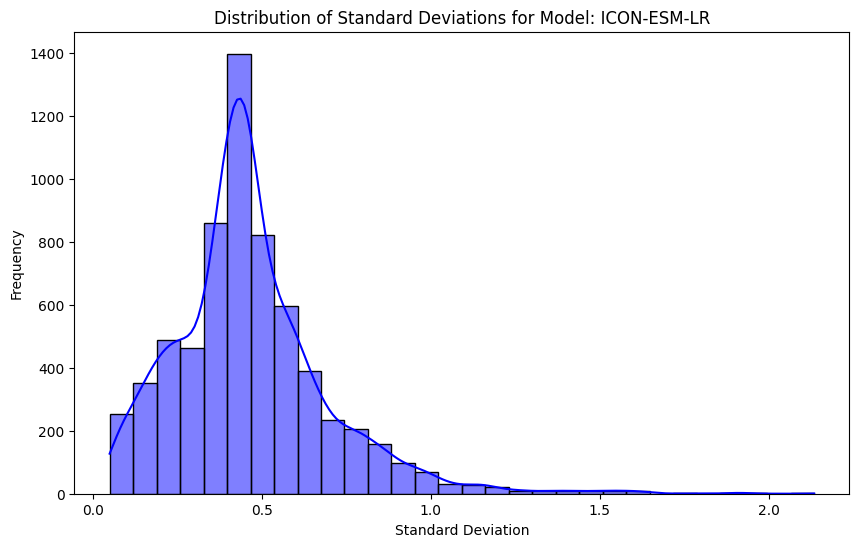

  3%|▎         | 1/34 [00:08<04:51,  8.84s/it]


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Data normalization completed.


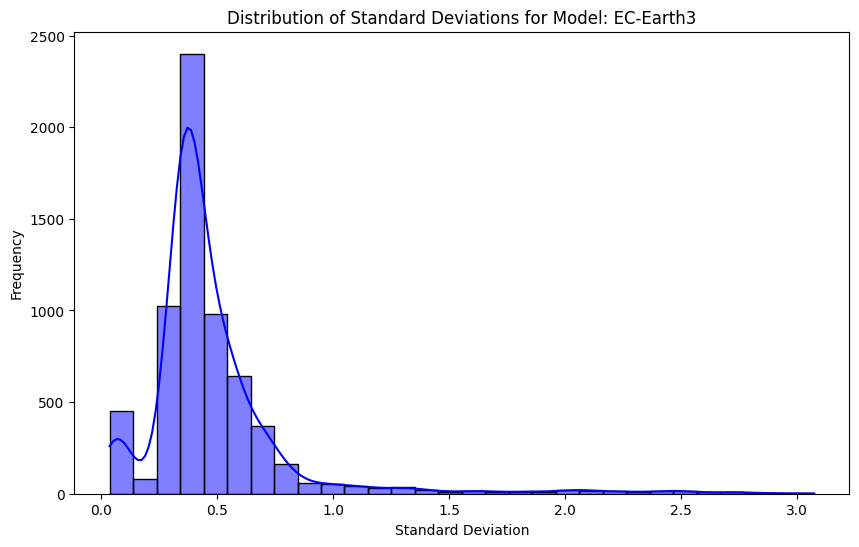

  6%|▌         | 2/34 [00:15<04:05,  7.67s/it]


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

Data normalization completed.


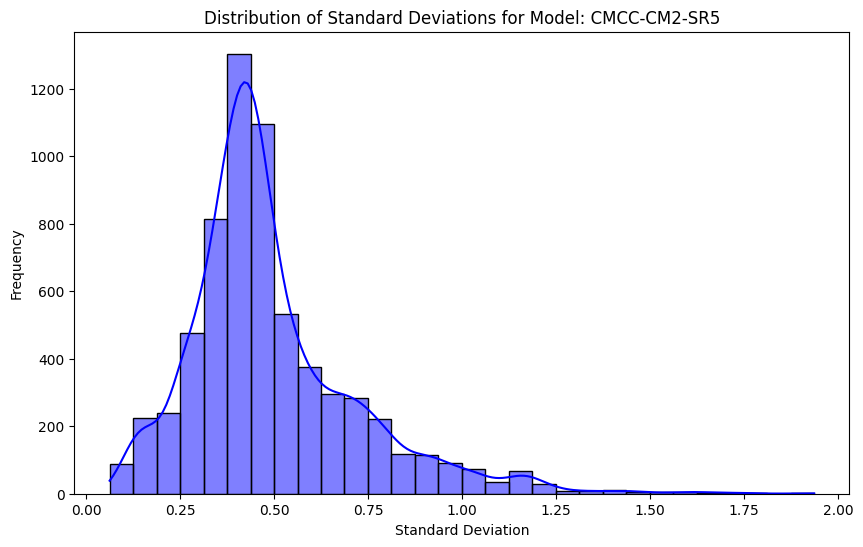

  9%|▉         | 3/34 [00:21<03:33,  6.89s/it]


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Data normalization completed.


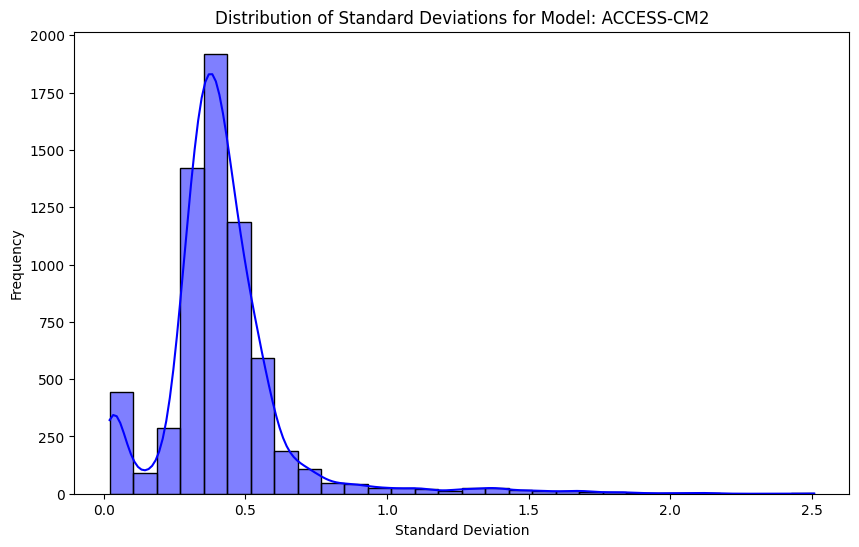

 12%|█▏        | 4/34 [00:31<04:07,  8.24s/it]


Normalizing data...


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

Data normalization completed.


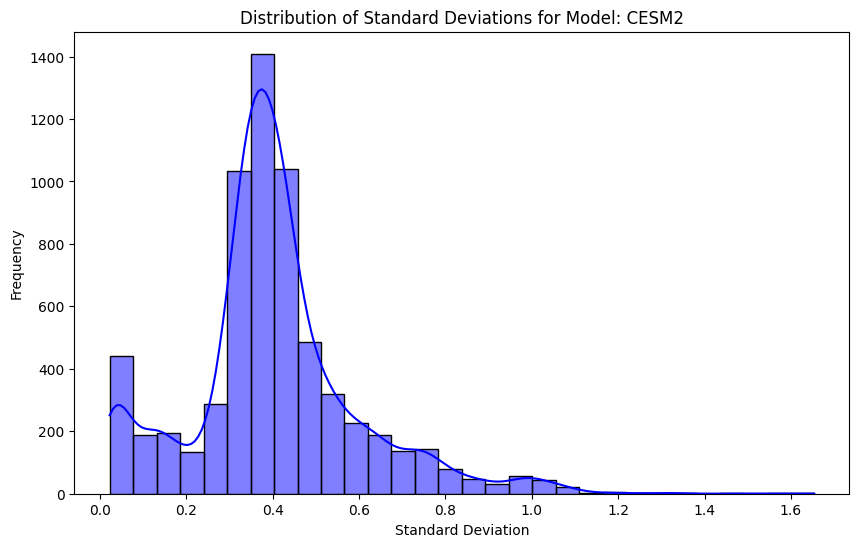

 15%|█▍        | 5/34 [00:38<03:42,  7.67s/it]


Normalizing data...


In [ ]:
# Initialize a dictionary to store the lowest STD value for each model
lowest_std_values = {}
worst_std_locations = {}
std_occurrence_map = np.zeros_like(nan_mask.ravel(), dtype=int)  # Vector to track occurrences of lowest STD positions

center = True
for test_model in tqdm(data):
    models = list(data.keys())
    # Normalize the data using the normalization function
    train_models = [model for model in models if model != test_model]
    train_data = {model: data[model] for model in train_models}
    test_data = {test_model: data[test_model]}
    normalized_train_data, normalized_test_data, _, testing_statistics = normalize_data(train_data, test_data, center=center)
    
    # Calculate the standard deviation of the normalized data
    std_values = testing_statistics[test_model]['std']
    
    # Store the smallest STD value for the current model
    lowest_std_values[test_model] = std_values.min()
    
    # Identify the location of the worst STD value
    worst_std_index = np.argmin(std_values)
    worst_std_locations[test_model] = std_values[worst_std_index]
    
    # Create a mask for all indices where the STD is less than 0.01
    low_std_mask = std_values < 0.01
    
    # Increment the occurrence map for all indices where the mask is True
    std_occurrence_map[np.where(low_std_mask)[0]] += 1
    
    # Plot the distribution of the standard deviations for the current model
    plt.figure(figsize=(10, 6))
    sns.histplot(std_values, bins=30, kde=True, color='blue')
    plt.title(f"Distribution of Standard Deviations for Model: {test_model}")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()
    
    # Do Garbage collection
    del normalized_train_data
    del normalized_test_data
    del testing_statistics

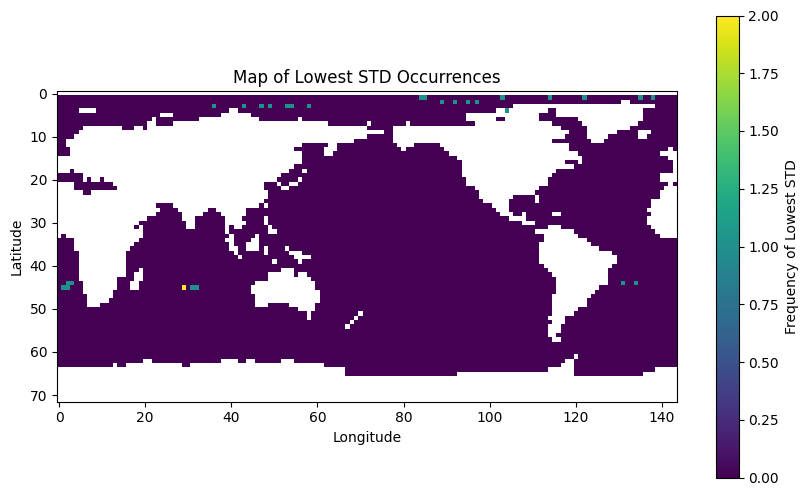

In [ ]:
# Manually handle NaN positions and reshape the occurrence map

# Create a full grid with NaN values
std_occurrence_with_nans = np.full(nan_mask.shape, np.nan)

# Fill the grid with the values from std_occurrence_map where nan_mask is False
std_occurrence_with_nans[~nan_mask] = std_occurrence_map[~nan_mask.ravel()]

# Reshape the data to 62x144 for plotting
reshaped_occurrence_map = std_occurrence_with_nans.reshape(72, 144)

# Plot the map of lowest STD occurrences
plt.figure(figsize=(10, 6))
plt.imshow(reshaped_occurrence_map, cmap='viridis', origin='upper')
plt.colorbar(label='Frequency of Lowest STD')
plt.title('Map of Lowest STD Occurrences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()